# <strong>爬取網站

In [1]:
import requests
from bs4 import BeautifulSoup
headers = {'user_agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.87 Safari/537.36 Edg/80.0.361.48'}
cookies = {'over18': '1'}
url = 'https://www.ptt.cc/bbs/Gossiping/index.html'

res = requests.get(url, headers=headers, cookies=cookies)
res.encoding = 'utf-8'
soup = BeautifulSoup(res.text, 'html.parser')

# <strong>解析網站HTML

In [2]:
datas = []
# 爬取前五頁
for i in range(20): 
    for article in soup.find_all('div', class_='r-ent'):
        try:
            info = {}
            title = str(article.find('div', class_='title').text).strip('\n')
            if '公告' in title:
                continue
            info['Title'] = title
            info['Author'] = article.find('div', class_='author').text
            url = 'https://www.ptt.cc/' + article.find('a')['href']
            info['Url'] = url
            soup2 = BeautifulSoup(requests.get(url, headers=headers, cookies=cookies).text, 'html.parser')
            main_content = soup2.find('div', id='main-content')
            info['Pub_time'] = main_content.find_all('span', class_='article-meta-value')[3].text
            for i in main_content.find_all('span', class_='f2'):
                if '來自' in str(i):
                    info['Author_ip'] = str(i).split(u'來自: ')[1].split(' (')[0]
            info['Content'] = str(main_content.text.split('2020')[1].split(u'發信站')[0]).replace('\n', ' ').strip()
            datas.append(info)
        except:
            pass
    url = 'https://www.ptt.cc/' + soup.find('div', class_='btn-group btn-group-paging').find_all('a')[1]['href']
    res = requests.get(url, headers=headers, cookies=cookies)
    res.encoding = 'utf-8'
    soup = BeautifulSoup(res.text, 'html.parser')


# <strong>輸出成DataFrame格式

In [3]:
import pandas as pd

df = pd.DataFrame(datas, columns=['Author', 'Author_ip', 'Pub_time', 'Url', 'Title', 'Content'])
df.set_index("Author" , inplace=True)
df.head(10)

,Author_ip,Pub_time,Url,Title,Content
Author,,,,,
botnet,180.204.34.68,Sat Feb 15 15:37:02 2020,https://www.ptt.cc//bbs/Gossiping/M.1581752224...,Re: [問卦] 禮拜六還要上班都是哪種人？:),和你說 補班日上班真的很爽 一堆人請特休，業務量超少 電話今天也沒響，整個block不...
chester0312,116.241.120.121,Sat Feb 15 15:37:05 2020,https://www.ptt.cc//bbs/Gossiping/M.1581752230...,[新聞] 大賣場內持刀輕生 墨國男送醫命危,1.媒體來源 蘋果日報 2.記者署名 突發中心 3.完整新聞標題: 大賣場內持刀輕生 ...
berger200350,42.73.43.246,Wed Feb 12 16:47:10 2020,https://www.ptt.cc//bbs/Gossiping/M.1581497232...,[徵求] 行車記錄器 國道北上17.7K 晚上18:3,國道發生車禍，想徵求行車記錄器 地點：國道北上 約17.7k（內湖成功路匝道口前方200公...
xodd123456,36.232.12.245,Wed Feb 12 17:30:29 2020,https://www.ptt.cc//bbs/Gossiping/M.1581499831...,[徵求] 行車記錄器 台中市向上路6段往中沙路,地點：台中市龍井區向上路六段中沙路機慢車道 時間：
moebius2,58.22.0.193,Sat Feb 15 15:28:18 2020,https://www.ptt.cc//bbs/Gossiping/M.1581751702...,Re: [問卦] 昨晚情人節，一個人最多可以趕幾攤?,※ 引述《RRADA (HIRO)》之銘言： : 2月14日情人節 : 我知道通常你們這些肥...
Ho1liday,36.239.240.165,Sat Feb 15 15:28:33 2020,https://www.ptt.cc//bbs/Gossiping/M.1581751719...,[新聞] 高大成反擊陸網友！「新冠肺炎感染上億人,ETtoday 高大成反擊陸網友！「新冠肺炎感染上億人」被出征 3霸氣回嗆：事實勝於雄辯 ...
rickey1270,117.19.236.119,Sat Feb 15 15:28:51 2020,https://www.ptt.cc//bbs/Gossiping/M.1581751734...,[問卦] 阿福能成為救國聖女嗎？,https://i.imgur.com/BNXqzfX.jpg 阿福可愛但阿福不說 身為...
rickey1270,117.19.236.119,Sat Feb 15 15:28:51 2020,https://www.ptt.cc//bbs/Gossiping/M.1581751735...,[問卦] 三億元換一個妹妹,我欠了大筆債務 為了還債用僅剩的存款拿去買了樂透彩券 想不到卻中了三億元…… 但我都還...
rickey1270,117.19.236.119,Sat Feb 15 15:28:52 2020,https://www.ptt.cc//bbs/Gossiping/M.1581751735...,[新聞] 丈夫返家見「嫩妻與友人狂飲爛醉」 8月女兒趴地上…頭顱滾,※發文無1~6小標格式或未依順序任意刪除者會被刪文 1.媒體來源: ※ 例如蘋果日報、自由...


# <strong>分群&排序

In [4]:
grouped = df.groupby('Author').count()
grouped.sort_values('Title', ascending=False).head(10)

,Author_ip,Pub_time,Url,Title,Content
Author,,,,,
oftisa,5,5,5,5,5
soweina1,4,4,4,4,4
bluebluelan,3,3,3,3,3
ak658865,3,3,3,3,3
Reewalker,3,3,3,3,3
rickey1270,3,3,3,3,3
ben780413,3,3,3,3,3
AppleMan,3,3,3,3,3
RRADA,2,2,2,2,2


# <strong>定義"移除停留字"方法

In [5]:
def remove_stop_words(file_name, seg):
    with open(file_name, 'r', encoding='utf-8') as f:
        stop_words = f.readlines()
    stop_words = [stop_word.strip() for stop_word in stop_words]
    if seg not in stop_words:
        return True
    
    

# <strong>定義"計算詞彙出現次數"方法

In [6]:
def count_segment_freq(seg_list):
    seg_df = pd.DataFrame(seg_list, columns=['seg'])
    seg_df['count'] = 1
    sef_freq = seg_df.groupby('seg')['count'].sum().sort_values(ascending=False)
    sef_freq = pd.DataFrame(sef_freq)
    return sef_freq

# <strong>使用jieba斷詞，並利用wordcloud繪出文字雲

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\USER\AppData\Local\Temp\jieba.cache
Loading model cost 1.030 seconds.
Prefix dict has been built successfully.


       count
seg         
今天         2
滑          2
電話         1
手機照        1
block      1
※          1
一堆         1
上班         1
不到         1
人請         1


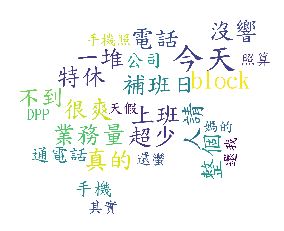

     count
seg       
墨西哥      8
警方       7
立即       5
現場       5
）        4
發現       4
自刎       4
民眾       4
輕生       4
目前       4


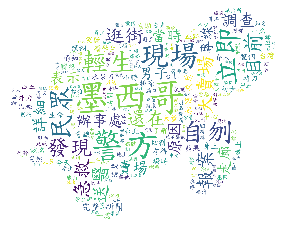

     count
seg       
國道       2
（        2
約        2
）        2
200      1
匝道       1
北上       1
前車       1
前方       1
公尺       1


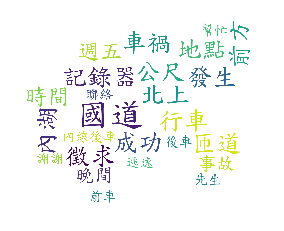

     count
seg       
龍井區      1
車道       1
機慢       1
時間       1
地點       1
台中市      1
六段       1
中沙路      1
上路       1


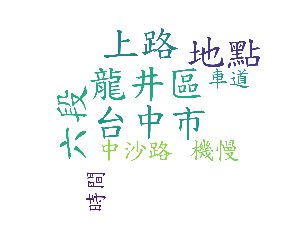

     count
seg       
█       62
◥       12
◣       10
◢       10
◤        9
▄        7
情人       5
節        4
～        3
一場       3


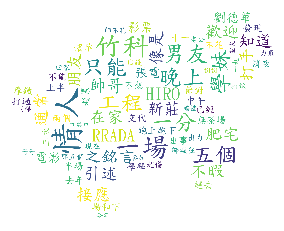

     count
seg       
高大       7
肺炎       4
新冠       4
中國       4
倍        4
感染       4
網友       3
出征       3
#        3
100      3


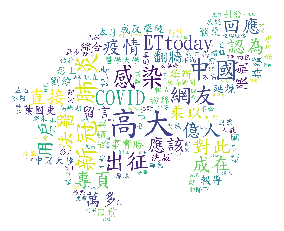

         count
seg           
gif         12
阿福           2
jpg          1
五百年          1
並在           1
※            1
vVrBOtM      1
rvDWmzR      1
nITXAx6      1
l17676s      1


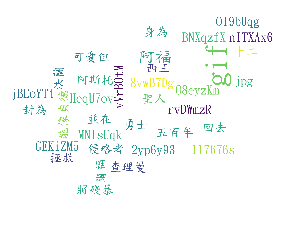

         count
seg           
gif         12
三            3
億元           2
女兒           2
…            2
還沒還          1
rvDWmzR      1
了門           1
中            1
一個           1


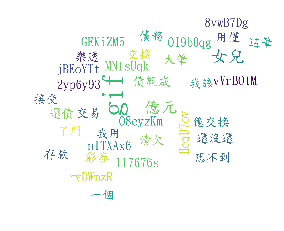

     count
seg       
※        7
（        6
死刑       6
白俄       5
羅        5
記者       5
）        5
夏亞       5
新聞       4
刪除       4


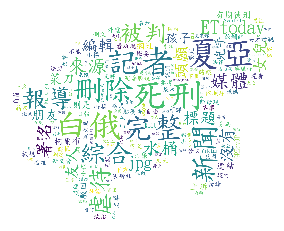

     count
seg       
學生       9
女校       7
男子       7
翻牆       5
事件       5
沒有       5
性侵       4
女生       4
祭        4
校長       4


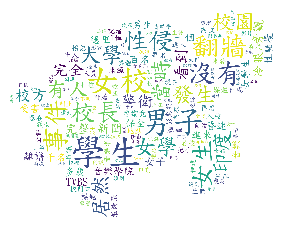

In [7]:
import imageio
import jieba.analyse
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# 自定義詞典
jieba.load_userdict('word.txt')
# 設定字型
font_path = 'kaiu.ttf'  # 標楷體

for i in range(10):
    seg_list = []
    text = df['Content'][i]
    for seg in jieba.cut(text, cut_all=False):
        if remove_stop_words('stop_word.txt', seg) and seg.strip() not in ['\n', '']:
            seg_list.append(seg)
    print(count_segment_freq(seg_list).head(10))
    seg_list = ' '.join(seg_list)
    
    back_pic = imageio.imread('turtle.jpg')
    wc = WordCloud(background_color='white', font_path=font_path, mask=back_pic)
    wc.generate(seg_list)
    plt.imshow(wc)
    plt.axis("off")
    plt.show()